# SITELLE GalaxyCAT
#### SITELLE Galaxy Cluster Analysis Tools
Ben Pennell


#### What is this?


This is extremely fragile code, with much dependence on the specific structure and file organization in the datacubes and on my machine.

What it does it uses 10 datacubes of galaxy clusters at z~0.23 from the SITELLE instrument aboard the CFHT, and it uses other code and data analysis that's already been done in addition to new data manipulation to create plots and visualizations to understand what is happening in these clusters.

Everything is held within a function, since some of these functions are powerful and can modify things such as fits header files, I don't want to accidentally run something that makes an irreversible change. Scroll all the way to the bottom, and there is a code block that you should use to run the functions.

# Functions

## Run these cells first

#### Imports

In [1]:
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.wcs import WCS
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord
from tabulate import tabulate

#### Constants and basic functions

In [61]:
RESOLUTION = 0.322 #arcsec/pix
SPEED_C = 2.998e5 # km/s

CUBES = ['A1736C', 'A2219C', 'A2390C', 'A2390NW', 'A2390SE', 'A2465C', 'A2465SW', 'A2465NE', 'RXJ2129C', 'RXJ2129S', 'RXJ2129W', 'ZWCL0823']
CUBES_REDUCED = ["A1736", "A2219", "A2390", "A2465", "RXJ21", "ZWCL0"]
REDSHIFTS = [0.2323, 0.2257, 0.228, 0.228, 0.228, 0.245, 0.245, 0.245, 0.2336, 0.2336, 0.2336, 0.2261]
REDSHIFTS_REDUCED = [0.2323, 0.2257, 0.228, 0.245, 0.2336, 0.2261]
R200S = [1830, 2241, 1930, 1930, 1930, "N/A", 1240, 1240, 1841, 1841, 1841, 1575]
DISPERSIONS = [1358, 1332, 1095, 1095, 1095, "N/A", 763, 722, 879, 879, 879, 671]
R200S_REDUCED = [1830, 2241, 1930, 1210, 1240, 1841, 1575] # IN KPC!!!!!
DISPERSIONS_REDUCED = [1358, 1332, 1095, 763, 722, 879, 671]
BCGS = {"A1736":[(203.8337946, 41.0011150)], 
        "A2219":[(250.08, 46.71)], 
        "A2390":[(328.403512, 17.695440)], 
        "A2465":[(339.918680, -5.723983), (339.852272, -5.788233)], 
        "RXJ21":[(322.41625, 0.08916667)], 
        "ZWCL0":[(126.49090442, 4.24659197)]}

CATALOGUE_KPC_PATH = "catalogue_dist_kpc.txt"
CATALOGUE_PHASE_PATH = "Phase_Diagram_Catalogue.txt"
FIELD_INDEX = 0
NAME_INDEX = 1
XPOS_INDEX = 2
YPOS_INDEX = 3
FLAG_INDEX = 5
HAZ_INDEX = 6
HASN_INDEX = 8
OTSN_INDEX = 11
KPC_INDEX = 15
PVEL_INDEX = 16 # Peculiar Velocity
DIST_INDEX = 17 # R / R200 distance

FITS_PATH = "E:\AstroResearch\SITELLE\{}\{}.deep_frame.fits"

In [3]:
def getWCS(field):
    hdul = fits.open(FITS_PATH.format(field, field), mode='readonly', memmap=False)
    header=hdul[0].header
    wcs=WCS(header)
    hdul.close()

    return wcs

def radecToPix(radec_coords, field):
    '''
        radec_coords (tuple of floats): (ra, dec) in degrees
        field (String): name of field (eg. "A2390C")
    '''
 
    wcs = getWCS(field)
        
    coords = SkyCoord(ra=radec_coords[0]*u.degree, dec=radec_coords[1]*u.degree, frame='icrs')
    x, y = wcs.world_to_pixel(coords)
    return (x, y)

def pixToRadec(pix_coords, field):
    wcs = getWCS(field)
    location = wcs.pixel_to_world(pix_coords[0], pix_coords[1])
    return (location.ra.deg, location.dec.deg)

def kpcToPix(distance_kpc, field):
    '''
        Converts a transverse distance in kpc to a distance in pixels
        Takes in the field, and the function will grab the redshift for it
        Uses astropy universe for a good approximation
    '''
    
    universe = FlatLambdaCDM(H0=70, Om0=0.3)

    angular_distance = universe.angular_diameter_distance(REDSHIFTS_REDUCED[CUBES_REDUCED.index(field[:5])]) # Mpc / rad

    angular_distance = angular_distance * 1000 # kpc / rad

    angular_distance = angular_distance / (180 / np.pi) / 3600 # kpc / arcsec

    angular_size = distance_kpc * RESOLUTION # arcsec

    distance_pix = angular_distance * angular_size # kpc
    
    return distance_pix.value

def radTokpc(distance_rad, field):
    redshift = REDSHIFTS_REDUCED[CUBES_REDUCED.index(field[:5])]

    universe = FlatLambdaCDM(H0=70, Om0=0.3)

    angular_distance = universe.angular_diameter_distance(redshift) # Mpc / rad

    angular_distance = angular_distance * 1000 # kpc / rad

    size = angular_distance * distance_rad # kpc

    return size.value

def kpcToRad(distance_kpc, field):
    redshift = REDSHIFTS_REDUCED[CUBES_REDUCED.index(field[:5])]

    universe = FlatLambdaCDM(H0=70, Om0=0.3)

    angular_distance = universe.angular_diameter_distance(redshift) # Mpc / rad

    angular_distance = angular_distance * 1000 # kpc / rad

    size = distance_kpc / angular_distance # rad

    return size.value

## Calculating Phase Diagrams

This is a multistep process
1. For each galaxy, determine the distance to nearest BCG
    1.1. Determine distance to BCG in radians
    1.2. Convert distance to kpc
    1.3. for A2465C, with two BCGs, use distance to closest BCG
2. Calculate r/r_200 using this distance in kpc and cluster r_200
3. Calculate vpec using galaxy velocity dispersion and relative redshift of galaxy
4. Append the rrel and vpec into new catalogue: Phase_Diagram_catalogue

In [4]:
def determine_distance(field, x_1, y_1, BCG_ra, BCG_dec, name=None):
    # x_1, y_1 are the galaxy

    wcs = getWCS(field)

    target_1 = wcs.pixel_to_world(x_1, y_1)

    # ra, dec
    dra = target_1.ra.deg - BCG_ra
    ddec = target_1.dec.deg - BCG_dec

    angle = np.sqrt((dra * np.cos(target_1.dec.rad))**2 + (ddec)**2) # THIS IS THE FORMULA
    #if(field == "A2390NW"):
        #print("{}: {},{} - {},{} - {},{}: {}".format(name, BCG_ra, BCG_dec, x_1, y_1, target_1.ra.deg, target_1.dec.deg, angle * 60))
    return np.radians(angle)
    
###########################################################

def determine_distance_BCG(field, x_1, y_1, returnBCG=False, set_BCG=None, name=None):
    angles = []
    field_bcgs = []
    if set_BCG is not None:
        field_bcgs = set_BCG
    else:
        field_bcgs = BCGS[field[:5]]

    for field_bcg in field_bcgs:
        angles.append(determine_distance(field, x_1, y_1, field_bcg[0], field_bcg[1], name=name))

    if returnBCG:
        # THIS IS THE OPTIONAL RETURN THAT INSTEAD RETURNS WHICH BCG WAS USED
        # This is used to determine which of multiple BCGs is closer in A2465
        minvalue = np.min(angles)
        index = angles.index(minvalue)
        return index
        
    return np.min(angles)

###########################################################

def determine_A2465_cluster(x, y):
    bcg = determine_distance_BCG("A2465C", x, y, returnBCG=True, set_BCG=BCGS["A2465"])

    if bcg == 0:
        return "NE"
    elif bcg == 1:
        return "SW"
    else:
        print("what?")
        return

In [46]:
def create_kpc_catalogue():
    catalogue = open("Catalogue.txt", "r")
    lines = catalogue.readlines()
    catalogue.close()

    newlines = lines.pop(0)[:-1] + " dist_kpc_BCG"
    for line in lines:
        elements = line.split(" ")

        field = elements[FIELD_INDEX]
        name = elements[NAME_INDEX]
        xpos = float(elements[XPOS_INDEX])
        ypos = float(elements[YPOS_INDEX])

        angular_sep = determine_distance_BCG(field, xpos, ypos, name=name)
        kpc_sep = radTokpc(angular_sep, field)

        newlines = newlines + "\n" + line[:-1] + " " + str(kpc_sep)

    outfile = open("catalogue_dist_kpc.txt", "w")
    outfile.write(newlines)

In [57]:
def calculatePhaseDiagram(flag_cutoff=0, hasn_cutoff=0, use_abs=False, outfile_name="Phase_Diagram_Catalogue"):
    infile = open("catalogue_dist_kpc.txt", "r")
    lines = infile.readlines()
    firstline = lines.pop(0)
    infile.close()

    outfile_path = "{}.txt".format(outfile_name)
    outfile_data = firstline[:-1] + " pvel dist\n"

    for line in lines:
        split_line = line.split(" ")
        field = split_line[FIELD_INDEX]
        flag = float(split_line[FLAG_INDEX])
        haSN = float(split_line[HASN_INDEX])

        if haSN > hasn_cutoff: # Making sure it's a good ha detection, since the catalogue also has far objects
            if flag >= flag_cutoff:
                dist_kpc = float(split_line[KPC_INDEX])
                redshift_ha = float(split_line[HAZ_INDEX])

                field_index = 0

                # A2465 is goofy because it's a merging cluster. We have to do some funky maneuvering to figure out which
                # While also making sure the regular clusters still work normally
                if field == "A2465C":
                    # In this case, we need to split it into A2465NE and A2465SW (index 3 and 4)
                    bcg = determine_A2465_cluster(float(split_line[XPOS_INDEX]), float(split_line[YPOS_INDEX]))
                    if bcg == "NE":
                        field_index = 3
                    elif bcg == "SW":
                        field_index = 4 
                elif field == "A2465NE":
                    field_index = 3
                elif field == "A2465SW":
                    field_index = 4
                else:
                    field_index = CUBES_REDUCED.index(field[:5])
                
                field_redshift = REDSHIFTS_REDUCED[field_index]
                field_r200 = R200S_REDUCED[field_index]
                field_dispersion = DISPERSIONS_REDUCED[field_index]

                distance_magnitude = dist_kpc / field_r200
                velocity_magnitude = (redshift_ha - field_redshift) * SPEED_C / field_dispersion / (1 + redshift_ha)

                if use_abs: velocity_magnitude = abs(velocity_magnitude)

                outfile_data = outfile_data + line[:-1] + " " + str(velocity_magnitude) + " " + str(distance_magnitude) + "\n"

    outfile = open(outfile_path, "w")
    outfile.write(outfile_data)

## Drawing Phase Diagrams

#### phaseDiagramByFlag()

In [7]:
def phaseDiagramByFlag():
    '''
        This function takes in the catalogue with peculiar velocity and relative distances
        And creates a phase diagram where each flag has different colours
    '''

    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    dists_by_flag = [[], [], [], []] #0, 1, 2, 3
    pvels_by_flag = [[], [], [], []]

    for datapoint in data:
        dist = float(datapoint[DIST_INDEX])
        pvel = float(datapoint[PVEL_INDEX])
        # There are just a couple objects that never have a flag for some reason, and they'll be ignored
        try:
            flag = int(datapoint[FLAG_INDEX])
            dists_by_flag[flag].append(dist)
            pvels_by_flag[flag].append(pvel)
        except:
            print("Failure: {}, {}".format(datapoint[0], datapoint[1]))

    plt.figure()
    for i in range(4):
        plt.scatter(dists_by_flag[i], pvels_by_flag[i], alpha=0.6, label="Flag = {}".format(i))
    
    plt.legend()
    plt.title("Phase Diagram By Flag For All Fields", fontsize=20)
    plt.xlabel("$R_{obj}/R_{200}$", fontsize=18)
    plt.ylabel("$(v_{obj} - v_{0})/σ_{v}$", fontsize=18)


#### phaseDiagramByField()

In [69]:

def phaseDiagramByField(separate=False):
    '''
        This function takes in the catalogue with peculiar velocity and relative distances
        And creates a phase diagram where each field has different colours

        separate=False (boolean): whether to draw them in separate images are all on top of each other
    '''

    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    dists_by_flag = [[], [], [], [], [], []] # Each cluster
    pvels_by_flag = [[], [], [], [], [], []]

    for object in data:
        dist = float(object[DIST_INDEX])
        pvel = float(object[PVEL_INDEX])
        field = object[FIELD_INDEX]
        index = CUBES_REDUCED.index(field[:5])

        dists_by_flag[index].append(dist)
        pvels_by_flag[index].append(pvel)

    if not separate:
        plt.figure()
    
    for i in range(len(CUBES_REDUCED)):
        if separate:
            plt.figure()
            plt.scatter(dists_by_flag[i], pvels_by_flag[i])
            plt.title("Phase Diagram for {}".format(CUBES_REDUCED[i]), fontsize=20)
            plt.xlabel("$R_{obj}/R_{200}$", fontsize=18)
            plt.ylabel("$(v_{obj} - v_{0})/σ_{v}$", fontsize=18)
        else:
            plt.scatter(dists_by_flag[i], pvels_by_flag[i], alpha=0.6, label="Field = {}".format(CUBES_REDUCED[i]))
    
    if not separate:
        plt.legend()
        plt.title("Phase Diagram By Field", fontsize=20)
        plt.xlabel("$R_{obj}/R_{200}$", fontsize=18)
        plt.ylabel("$(v_{obj} - v_{0})/σ_{v}$", fontsize=18)


#### phaseDiagramBySN()

In [9]:

def phaseDiagramBySN(groupCount=4):
    '''
        Creates phase diagrams depending on Ha and OIII signal to noise ratios
    '''
    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    SNs = [[],[]] # Ha, OIII
    phase = [[],[]] # peculiar velocity, relative distance


    for i, object in enumerate(data):
        SNs[0].append(float(object[HASN_INDEX]))
        SNs[1].append(float(object[OTSN_INDEX]))

        phase[0].append(float(object[PVEL_INDEX]))
        phase[1].append(float(object[DIST_INDEX]))
    
    for i, template in enumerate(["Hα SN", "OIII SN"]):
        plt.figure()
        SNRatios = SNs[i]
        for j in range(groupCount):
            cutoff_lower = j / groupCount * 100
            cutoff_upper = (j + 1) / groupCount * 100

            peculiar_velocities = []
            relative_distances = []

            for k, ratio in enumerate(SNRatios):
                if ratio <= np.percentile(SNRatios, cutoff_upper) and ratio > np.percentile(SNRatios, cutoff_lower):
                    vels = phase[0]
                    dists = phase[1]

                    peculiar_velocities.append(vels[k])
                    relative_distances.append(dists[k])
        
            plt.scatter(relative_distances, peculiar_velocities, alpha=0.6, label="{} to {} Percentile".format(int(cutoff_lower), int(cutoff_upper)))
        
        plt.legend()
        plt.title("Phase Diagram By {}".format(template), fontsize=20)
        plt.xlabel("$R_{obj}/R_{200}$", fontsize=18)
        plt.ylabel("$(v_{obj} - v_{0})/σ_{v}$", fontsize=18)

#### phaseDiagramBySNMagnitude()

In [10]:

def phaseDiagramBySNMagnitude(draw_plots=True, return_values=False, return_indices=False):
    '''
        This creates a regular phase diagram but removes any object with a higher OIII S/N than Hα S/N and plots them seperately
    '''
    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")
    pvels_outlier = []
    dists_outlier = []
    pvels = []
    dists = []

    indices = []

    for i, object in enumerate(data):
        SN_Ha = float(object[HASN_INDEX])
        SN_OIII = float(object[OTSN_INDEX])

        if SN_Ha < SN_OIII:
            pvels_outlier.append(float(object[PVEL_INDEX]))
            dists_outlier.append(float(object[DIST_INDEX]))

            indices.append(i)
        else:
            pvels.append(float(object[PVEL_INDEX]))
            dists.append(float(object[DIST_INDEX]))
        

    if return_values:
        return (dists, pvels), (dists_outlier, pvels_outlier)
    
    if return_indices:
        return indices

    if draw_plots:
        plt.figure()
        plt.scatter(dists, pvels, alpha=0.6, label="Higher Ha S/N")
        plt.scatter(dists_outlier, pvels_outlier, alpha=0.6, label="Higher OIII S/N")    
        plt.legend()
        plt.title("Phase Diagram Separating High and Low Ha S/N", fontsize=20)
        plt.xlabel("$R_{obj}/R_{200}$", fontsize=18)
        plt.ylabel("$(v_{obj} - v_{0})/σ_{v}$", fontsize=18)

#### distributionByVpec()

In [11]:
def distributionByVpec(slice_size=0.2):
    '''
        This function takes the phase diagram, creates vertical slices and determines relative ratios
        of OIII and Hα preferred object in each slice to see how the OIII objects are distributed
        From the function phaseDiagramBySNMagnitude
    '''
    
    regulars, outliers = phaseDiagramBySNMagnitude(draw_plots=False, return_values=True)
    
    regular_dists = regulars[0]
    outlier_dists = outliers[0]
    
    regular_bucket = []
    outlier_bucket = []
    
    
    for dist in regular_dists:
        regular_bucket.append(int(dist / slice_size))
    
    for dist in outlier_dists:
        outlier_bucket.append(int(dist / slice_size))
    
    regular_bucket = np.array(regular_bucket)
    outlier_bucket = np.array(outlier_bucket)
    
    buckets = []
    ratios = []
    
    for i in range(np.max([np.max(regular_bucket), np.max(outlier_bucket)])):
        buckets.append((i + 0.5) * slice_size)
        regular_bucket_i = regular_bucket[regular_bucket==i]
        outlier_bucket_i = outlier_bucket[outlier_bucket==i]
        
        denominator = 1
        if len(regular_bucket_i) != 0:
            denominator = len(regular_bucket_i)

        numerator = 0
        if len(outlier_bucket_i) != 0:
            numerator = len(outlier_bucket_i)
            
        ratio = (numerator/denominator)
        ratios.append(ratio)

    plt.figure()
    plt.plot(buckets, ratios)
    plt.title("Ratio of OIII to Hα preference in phase diagram with buckets={}".format(slice_size), fontsize=20)
    plt.xlabel("$R_{obj}/R_{200}$", fontsize=18)
    plt.ylabel("$N_{OIII}/N_{Hα}$", fontsize=18)

## Right Ascension / Declination Plots

#### radecPlot()
Right ascension/declination plots for every object in every cluster

Run this cell before running any of the others. All other ra/dec plots inherit from this one

In [12]:
def radecPlot(draw_plots=True, return_field=None):
    '''
        This takes every object in the catalogue and plots their ra/dec position
        Of course, all the values in the catalogue are in x,y so WCS must be use to get coordinates
        This will handle every field at once, and it does this through a goofy mechanism:
        There is a CUBE_REDUCED array of each field's first five characters
        the index of the field in that array implies the index in the RA_values and Dec_values array

        draw_plots (boolean): whether to make the plot or not. Default=True
        return_field (String): which reduced field to return, (eg. "A2390" or "RXJ21")
    '''

    ra_values = [[],[],[],[],[],[]]
    dec_values = [[],[],[],[],[],[]]

    field_indices = []

    data = np.loadtxt(CATALOGUE_KPC_PATH, skiprows=1, delimiter=" ", dtype="str")
    
    for i, line in enumerate(data):
        # Determine RA and Dec for each object in the catalogue, line by line
        field = line[FIELD_INDEX]
        xPos = float(line[XPOS_INDEX])
        yPos = float(line[YPOS_INDEX])

        wcs = getWCS(field)

        position = wcs.pixel_to_world(xPos, yPos)

        ra_value = position.ra.deg
        dec_value = position.dec.deg

        field_index = CUBES_REDUCED.index(field[:5])

        ra_values[field_index].append(ra_value)
        dec_values[field_index].append(dec_value)

        if return_field is not None:
            if field_index == CUBES_REDUCED.index(return_field[:5]):
                field_indices.append(i) 
    
    if draw_plots:
        for i in range(len(CUBES_REDUCED)):
            # Draw each plot and save them
            plt.figure()
            plt.scatter(dec_values[i], ra_values[i])
            plt.title("Celestial Coordinates of Objects in {}".format(CUBES_REDUCED[i]))
            plt.xlabel("Declination (degrees)")
            plt.ylabel("Right Ascension (degrees)")
    
    if return_field is not None:
        return dec_values[CUBES_REDUCED.index(return_field[:5])], ra_values[CUBES_REDUCED.index(return_field[:5])], field_indices

#### radecHighPeculiarVelocityPlot()
Right ascension/declination plot differentiating high velocity outliers

This function inherits from: radecPlot()

In [13]:
def radecHighPeculiarVelocityPlot(field, pvel_cutoff=5):
    '''
        This function will do a radec plot but plot the objects with high peculiar velocity in a differnet colour

        field (String): name of the field (eg. "A2390C")
        pvel_cutoff (float): peculiar velocity cutoff point for an object to be an "outlier". defaults to 5
    '''
    decs, ras, indices = radecPlot(draw_plots=False, return_field=field)

    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    outlier_decs = []
    outlier_ras = []

    for i, index in enumerate(indices):
        entry = data[index]
        pvel = float(entry[PVEL_INDEX])

        if pvel > pvel_cutoff:
            outlier_decs.append(decs[i])
            outlier_ras.append(ras[i])
    
    plt.figure()
    plt.scatter(decs, ras)
    plt.scatter(outlier_decs, outlier_ras, label="Outliers (pvel > {})".format(pvel_cutoff))
    plt.title("ra/dec plot for {} seperated by pvel".format(field))
    plt.legend()
    plt.xlabel("Declination (degrees)")
    plt.ylabel("Right Ascension (degrees)")

#### radecSNPreferencePlot
Right ascension/declination plot differentiated by signal to noise ratio preference (OIII or Hα)

This function inherits from: radecPlot() and phaseDiagramBySNMagnitude()

In [14]:
def radecSNPreferencePlot(field):
    '''
    '''

    outlier_indices = phaseDiagramBySNMagnitude(draw_plots=False, return_indices=True)

    decs, ras, indices = radecPlot(draw_plots=False, return_field=field)

    outlier_decs = []
    outlier_ras = []

    for i, index in enumerate(indices):
        if index in outlier_indices:
            outlier_decs.append(decs[i])
            outlier_ras.append(ras[i])

    plt.scatter(decs, ras)
    plt.scatter(outlier_decs, outlier_ras, label="Outliers")
    plt.title("ra/dec plot for {} seperated by S/N preference".format(field))
    plt.legend()
    plt.xlabel("Declination (degrees)")
    plt.ylabel("Right Ascension (degrees)")
    plt.show()
    plt.clf()

#### findOverlappingObjects()

In [15]:
def findOverlappingObjects(max_separation=0.001):
    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    objects = []
    # objects[i] = [field, name, ra, dec]

    found = []
    # found[i] = [field_1, name_1, field_2, name_2, dist (deg)]

    for line in data:
        # Determine RA and Dec for each object in the catalogue, line by line
        field = line[FIELD_INDEX]
        if field[:5] == "A2390" or field[:5] == "A2465": # Only use the clusters with multiple fields
            name = line[NAME_INDEX]
            xPos = float(line[XPOS_INDEX])
            yPos = float(line[YPOS_INDEX])

            wcs = getWCS(field)

            position = wcs.pixel_to_world(xPos, yPos)

            ra_value = position.ra.deg
            dec_value = position.dec.deg

            # Check if it is close to any previous object
            for object in objects:
                if object[0] != field: # Exlude objects within the same field
                    dist = (object[2] - ra_value)**2 + (object[3] - dec_value)**2
                    if dist < max_separation**2:
                        found.append([object[0], object[1], field, name, np.sqrt(dist)])
                
            objects.append([field, name, ra_value, dec_value])
    
    print(tabulate(found))

## Miscellaneous

#### getOutlierRate()

In [16]:
def getOutlierRate(pvel_cutoff=3):
    '''
        Outputs a table that shows for each field their outlier rate
        "outliers" are galaxies with peculiar velocities greater than 3 (or any other cutoff, designated by pvel_cutoff)
        It will also print out the R200, Velocity Dispersion and total object count for each field
    '''
    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    objects = np.zeros(len[CUBES])
    outliers = np.zeros(len[CUBES])

    for object in data:
        field = object[FIELD_INDEX]
        pvel = float(object[PVEL_INDEX])

        # determine which index to use based on the field
        index = CUBES.index(field)
        objects[index] += 1

        if pvel >= pvel_cutoff:
            outliers[index] += 1

    rates = (outliers / objects).round(decimals=3)
    objects = objects.astype(int)
    outliers = outliers.astype(int)
    
    print(tabulate([CUBES, R200S, DISPERSIONS, objects, outliers, rates], tablefmt="simple_grid"))

#### coverage()

In [17]:
def coverage(cluster="A2390C", depth=10000, bucket_size=0.02, max_r200=2):
    '''
        Determines the coverage of a given cluster by radius out to 2R200
        This function is simpler but less complete than coverage_2(). This function cannot do the multi-field clusters like A2390, but, it doesn't need to read in the header files.

        How it works:
        for each radius outwards, generate a 1000 points within that distance. Find out how many are within the image and calculate coverage rate
        
        cluster (String): chosen cluster (eg. "A2390C")
        depth (int): number of points to throw in the monte carlo simulation
    '''
    
    bcg = BCGS[cluster[:5]][0]
    bcg_location = radecToPix(bcg, cluster)
    bcg_x = bcg_location[0]
    bcg_y = bcg_location[1]
    
    r200 = R200S_REDUCED[CUBES_REDUCED.index(cluster[:5])]

    #intervals of 5% r200
    dist_multipliers = np.arange(0, max_r200, bucket_size)
    dist_kpcs = dist_multipliers * r200
    dist_pixs = kpcToPix(dist_kpcs, cluster)
    
    ratios = []
    
    for dist_cutoff in dist_pixs:
        within_count = 0

        for point in range(depth):
            dx = np.random.rand() * dist_cutoff
            dy = np.random.rand() * dist_cutoff
            
            point_x = bcg_x + dx
            point_y = bcg_y + dy

            within_image = (point_x > 0 and point_y > 0 and point_x < 2064 and point_y < 2048)

            if within_image:
                within_count += 1
            
        ratios.append(within_count / depth)
    
    plt.figure()
    plt.plot(dist_multipliers, ratios)

In [18]:
def coverage_stripped(cluster="A2390C", depth=10000, bucket_size=0.02, max_r200=2):
    bcg_location = radecToPix(BCGS[cluster[:5]][0], cluster)
    dist_multipliers = np.arange(0, max_r200, bucket_size)
    ratios = []
    for dist_cutoff in kpcToPix(dist_multipliers * R200S_REDUCED[CUBES_REDUCED.index(cluster[:5])], cluster):
        within_count = 0
        for _ in range(depth):
            point_x = bcg_location[0] + np.random.rand() * dist_cutoff
            point_y = bcg_location[1] + np.random.rand() * dist_cutoff
            if (point_x > 0 and point_y > 0 and point_x < 2064 and point_y < 2048): within_count+=1
        ratios.append(within_count / depth)
    plt.figure()
    plt.plot(dist_multipliers, ratios)

#### coverage_2()
Just like coverage(), except it can do multi-field clusters

In [19]:
def minmaxRadec(field="A2390C"):
    # min ra, min dec, max ra, max dec
    radec_mins = pixToRadec((0,0), field)
    radec_maxs = pixToRadec((2064,2048), field)

    return np.min([radec_mins[0], radec_maxs[0]]), np.min([radec_mins[1], radec_maxs[1]]), np.max([radec_mins[0], radec_maxs[0]]), np.max([radec_mins[1], radec_maxs[1]])

def coverage_2(cube="A2390", depth=10000, bucket_size=0.02, max_r200=2):
    fields = []
    extremas = []
    for field in CUBES:
        if cube in field:
            fields.append(field)
            extremas.append(minmaxRadec(field))

    bcg = BCGS[cube[:5]][0]
    bcg_ra = bcg[0]
    bcg_dec = bcg[1]
    
    r200 = R200S_REDUCED[CUBES_REDUCED.index(cube[:5])]
    r200_deg = np.rad2deg(kpcToRad(r200, fields[0]))
    #intervals of 5% r200
    dist_multipliers = np.arange(0, max_r200, bucket_size)
    dist_degs = dist_multipliers * r200_deg
    
    ratios = []
    
    offsets = ( np.random.rand(depth, 2) * 2 ) - 1

    all_x = []
    all_y = []

    success_x = []
    success_y = []

    for dist_cutoff in dist_degs:
        within_count = 0

        for offset in offsets:
            dra = offset[0] * dist_cutoff
            dec_max = np.sqrt(dist_cutoff**2 - dra**2)
            ddec = offset[1] * dec_max
            
            point_ra = bcg_ra + dra
            point_dec = bcg_dec + ddec

            all_x.append(point_ra)
            all_y.append(point_dec)

            for extrema in extremas:
                if (point_ra > extrema[0] and point_dec > extrema[1] and point_ra < extrema[2] and point_dec < extrema[3]):
                    within_count += 1
                    success_x.append(point_ra)
                    success_y.append(point_dec)
            
        ratios.append(within_count / depth)
    
    plt.figure()
    plt.plot(dist_multipliers, ratios)
    
    plt.figure()
    plt.scatter(all_x, all_y, color="red")
    plt.scatter(success_x, success_y, color="blue")
    

#### pullToFolder()

In [20]:
import os
import shutil

def pullToFolder(infile_path, inimage_path, outfolder_name, field_index=0, name_index=1, delimiter=" "):
    '''
        This function takes in a path for a catalog of objects, and a folder that contains images of those objects (among others). 
        It will pull the images corresponding to the objects in the catalogue into a destination folder.

        The catalog must have a column for the field, and a column for the name. Something like this: A2390 1797 
        You can set whatever indices you need for those two, and the delimiter.

        infile_path (String): path of catalog with field and object names
        inimage_path (String): path of folder with images to pull from
        outfolder_name (String): destination folder

        field_index=0 (int)
        name_index=1 (int)
        delimiter=" " (String)
    '''
    outFolder = "./" + outfolder_name

    try:
        os.mkdir(outFolder)
    except:
        print("Folder already exists")

    lines = np.loadtxt(infile_path, skiprows=1, delimiter=delimiter, dtype="str")

    for line in lines:
        field = line[field_index]
        name = line[name_index]

        files = os.listdir(inimage_path + "/" + field)

        for file in files:
            # the files are named field#name.png
            splitfile = file.split("#")
            if splitfile[1][:-4] == name:
                shutil.copy2(inimage_path + "/" + field + "/" + file, outFolder)

#### collectFarOIIIObjects()

In [21]:
def collectFarOIIIObjects(outfile_path="farOIIIObjects.txt", min_r200=1):
    '''
        This functions collects objects from all fields with OIII S/N preference far from the cluster center

        min_r200=1 (float): how many r200s to start collecting objects from
    '''

    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    output = ""

    for object in data:
        SN_Ha = float(object[HASN_INDEX])
        SN_OIII = float(object[OTSN_INDEX])
        dist = float(object[DIST_INDEX])

        if dist > min_r200 and SN_OIII > SN_Ha:
            output = output + "\n" + " ".join(object)
    
    outfile = open(outfile_path, "w")
    outfile.write(output)
    outfile.close()



#### highNegativePvels()

In [22]:
def highNegativePvels(cutoff=3):
    data = np.loadtxt(CATALOGUE_PHASE_PATH, skiprows=1, delimiter=" ", dtype="str")

    flagged_objects = []

    for object in data:
        field = object[FIELD_INDEX]
        name = object[NAME_INDEX]
        pvel = float(object[PVEL_INDEX])

        if pvel < 0 and abs(pvel) > cutoff:
            flagged_objects.append([field, name, pvel])
    
    print(tabulate(flagged_objects))

## Catalogues and working with fits files

#### Changing headers example

In [23]:
import astropy.io.fits as fits
'''
    This function takes a list of header entries in one header and moves them to another
'''

def changeHeader():
    FIELD = "A2390NW"
    THINGS_TO_CHANGE = ["CTYPE1", "CTYPE2", "CRVAL1", "CRPIX1", "CRVAL2", "CRPIX2"]

    source_fits = "E:/SITELLE/AstroResearch/{}/{}.fits".format(FIELD, FIELD)
    target_fits = "E:/SITELLE/AstroResearch/{}/{}.deep_frame.fits".format(FIELD, FIELD)

    hdul = fits.open(source_fits, mode='readonly', memmap=False) # open source fits file
    source_header = hdul[0].header # get the header

    for header_entry in THINGS_TO_CHANGE:
        fits.setval(target_fits, header_entry, value=source_header[header_entry])  # set the values using fits.setval()

#### createCatalogue()

In [41]:
import pickle

def createCatalogue(elg_lists_path, SITELLE_path):
    '''
        This script takes all the redshift, R, S/N fits from all the templates in Qing's SITELLE_ELG_Finder
        extracts them from the pickle file and creates a catalogue
        
            1        2       3        4        5       6       7               8       9       10        11        12        13          14       15       16
    '''
    labels = ["field", "name", "x_loc", "y_loc", "eq_r", "flag", "rad_dist_BCG", "Ha_z", "Ha_R", "Ha_S/N", "OIII_z", "OIII_R", "OIII_S/N", "OII_z", "OII_R", "OII_S/N"]
    # Write top line of file
    outlabel = " ".join(labels)
    outfile = open("Catalogue.txt", "w")
    outfile.write(outlabel)

    path = elg_lists_path + "/"
    ending = "_ELG_list.txt"

    for field in CUBES:
        infile = open("{}/{}/{}/{}-cc-MMA_lpf.pkl".format(SITELLE_path, field, field, field), 'rb')
        pickle_dict = pickle.load(infile)
        infile.close()

        lines = np.loadtxt("{}{}{}".format(path, field, ending), skiprows=1, delimiter=" ", dtype="str")

        for line in lines:
            output = []

            name = line[0]
            x_loc = line[1]
            y_loc = line[2]
            
            output.append(field) # field
            output.append(name) # name
            output.append(x_loc)
            output.append(y_loc)
            output.append(line[5]) # eq_r
            output.append(line[10]) # flag

            output.append(pickle_dict['Ha-NII_gauss'][name]['z_best']) #Ha_z
            output.append(pickle_dict['Ha-NII_gauss'][name]['R']) #Ha_R
            output.append(pickle_dict['Ha-NII_gauss'][name]['SNR']) #Ha_S/N

            output.append(pickle_dict['Hb-OIII_gauss'][name]['z_best']) #OIII_z
            output.append(pickle_dict['Hb-OIII_gauss'][name]['R']) #OIII_R
            output.append(pickle_dict['Hb-OIII_gauss'][name]['SNR']) #OIII_S/N

            output.append(pickle_dict['OII_gauss'][name]['z_best']) #OII_z
            output.append(pickle_dict['OII_gauss'][name]['R']) #OII_R
            output.append(pickle_dict['OII_gauss'][name]['SNR']) #OII_S/N

            outfile.write("\n")
            outfile.write(" ".join(map(str, output)))

#### Region file example

In [25]:
def map_numb(number, elements, tarmin, tarmax):
    '''
        This function maps a number based on what percentile it is in a set
        for example: map the object of the 70th percentile onto (0, 255), it would have a value of 0.7 x 255 = 178.5
        this is used to create the colour distance gradient for createRegionFile()
    '''
    greatercount = 1
    lessercount = 1
    for item in elements:
        if number >= item:
            greatercount += 1
        else:
            lessercount += 1

    percentile = (greatercount) / (lessercount + greatercount)
    
    mapped_number = 255 * percentile
    
    return mapped_number

def createRegionFile(filename="catalogue_dist_rad.txt", field="A2390C", delimiter=" ", xindex=2, yindex=3, distindex=15, circlesize=5):
    '''
        This script will create a .txt file containing regions for each object in a given cluster
        Each region will be a different grayscale colour based on percentile distance. black=close, white=far
    '''

    COLORMIN = 000
    COLORMAX = 255

    lines = np.loadtxt(filename, skiprows=1, delimiter=delimiter, dtype="str")

    xLocs = []
    yLocs = []
    dists = []

    # get position of each object and distance from BCG
    for line in lines:
        fieldname = line[0]
        
        if fieldname == field:
            xLocs.append(line[xindex])
            yLocs.append(line[yindex])
            dists.append(float(line[distindex]))
    
    # open output file and write global information
    outfile = open("regions_by_distance_{}.reg".format(field), "w")
    outfile.write("global width=8\nIMAGE\n")
    
    # write in the circle for each object
    for i in range(len(xLocs)):
        # get the colour in the gradient
        mapped_color = int(map_numb(dists[i], dists, COLORMIN, COLORMAX)) #This generates a number 0-255, a grayscale colour
        
        # convert the colour to hex (RGB somehow doesn't work)
        color = str(hex(mapped_color))[2:] * 3

        # write in the circle for the object
        outfile.write("circle({},{},{}) # color=#{}\n".format(xLocs[i], yLocs[i], str(circlesize), color))

#### WCS and wcs.pixel_to_world test

In [26]:
def pixelWorldComparison(field="A2390C", catalogue_path="catalogue_dist_rad.txt"):
    '''
        This script will take each galaxy identified by Qing's code, use WCS to get the ra/dec position, then create a region file to be drawn in DS9
        This is done to check if the WCS or pixel_to_world is being problematic
    '''

    SIZE = 5

    wcs = getWCS(field)

    data = np.loadtxt(catalogue_path, skiprows=1, delimiter=" ", dtype="str")

    x_locations = []
    y_locations = []
    ra_positions = []
    dec_positions = []

    for object in data:
        field = object[FIELD_INDEX]
        if field == "A2390C":
            xLoc = float(object[XPOS_INDEX])
            yLoc = float(object[YPOS_INDEX])

            x_locations.append(xLoc)
            y_locations.append(yLoc)

            target_1 = wcs.pixel_to_world(xLoc, yLoc)

            ra_positions.append(target_1.ra.deg)
            dec_positions.append(target_1.dec.deg)

    cartesian_reg = open("{}_cartesian_positions.reg".format(field), "w")
    cartesian_reg.write("global width=8 color=green\nIMAGE")

    skycoords_reg = open("{}_skycoods_positions.reg".format(field), "w")
    skycoords_reg.write("global width=8 color=red\nFK5")

    for i in range(len(x_locations)):
        cartesian_reg.write("\ncircle({},{},{})".format(x_locations[i], y_locations[i], SIZE))
        skycoords_reg.write("\ncircle({},{},2\")".format(ra_positions[i], dec_positions[i]))

#### appendColumns()

In [29]:
def appendColumns(path="E:\Summer Project 2022\ELG_Lists\A2390C_ELG_list.txt", count=1, position=None):
    '''
        This function takes in a catalogue and appends 0s to fill columns

        position=None (int): which column to append after (if you want to append 0s in between columns). none means append to end.
    '''

    # open and read in the catalogue
    infile = open(path, "r")
    lines = infile.readlines()
    infile.close()

    # create a new one THIS MAKES THE CODE DANGEROUS
    outfile = open(path, "w")

    for line in lines:
        line = line.split(" ")
        outline = ""

        # add each line back into the output
        for i, word in enumerate(line):
            word = word.strip()
            outline += word + " "

            # if you're using the positon, check if you're in the right position
            if position is not None:
                if i == position:
                    for _ in range(count):
                        outline += "0 "
        # if not using position, add to the end
        if position is None:
            for _ in range(count):
                outline += "0 "
                    
        outline += "\n"
        outfile.write(outline)

# Run your code here
Call the functions you need, and further manipulations that you want to make, in this code cell

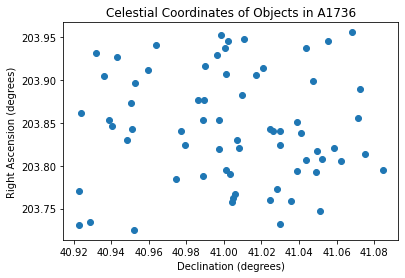

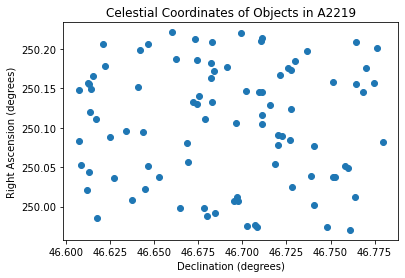

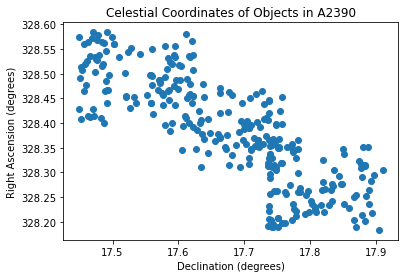

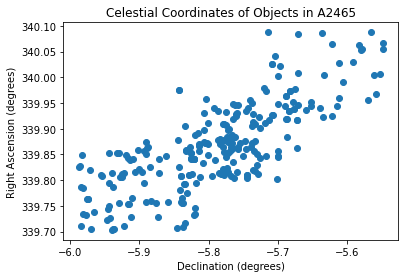

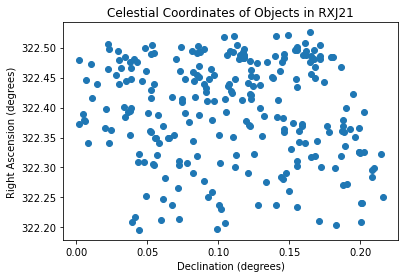

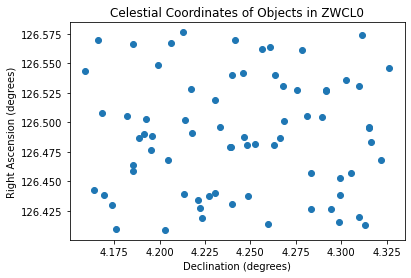

In [74]:
'''
    Use this cell to run your code
'''

#appendColumns(path="E:/AstroResearch/GalaxyCAT/ELG_lists/RXJ2129W_ELG_list.txt", count=3)

#createCatalogue("./ELG_lists", "E:/AstroResearch/SITELLE/")

#create_kpc_catalogue()

#calculatePhaseDiagram(flag_cutoff=2, use_abs=True)

#phaseDiagramByField()
#phaseDiagramByField(separate=True)

#for cube in CUBES_REDUCED:
    #coverage_2(cube=cube)

radecPlot()